In [31]:
import datetime as dt
import yfinance as yf

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
def addRSI(data, ruedas):
    df = data.copy()
    df['dif'] = df['Adj Close'].diff()
    df['win'] = np.where(df['dif'] > 0, df['dif'], 0)
    df['loss'] = np.where(df['dif'] < 0, abs(df['dif']), 0)
    df['ema_win'] = df.win.ewm(alpha=1/ruedas).mean()
    df['ema_loss'] = df.loss.ewm(alpha=1/ruedas).mean()
    df['rs'] = df.ema_win / df.ema_loss
    df['rsi_'+str(ruedas)] = 100 - (100 / (1+df.rs))
    data['rsi_'+str(ruedas)] = df['rsi_'+str(ruedas)]
    return data

In [34]:
def addMACD(data, slow=26, fast=12, suavizado=9):
    df = data.copy()
    df['ema_fast'] = df['Adj Close'].ewm(span=fast).mean()
    df['ema_slow'] = df['Adj Close'].ewm(span=slow).mean()
    df['macd'] = df.ema_fast - df.ema_slow
    df['signal'] = df.macd.ewm(span=suavizado).mean()
    df['histograma'] = df.macd - df.signal
    df = df.dropna().round(2)
    data['histo_macd']= df['histograma'] 
    return data

In [35]:
def get_train_features(df):
    df_sel = df.values 
    df_scaled = scaler.fit_transform(df_sel)  # Normalize data

    features_set = []  
    labels = []  
    for i in range(time_steps, len(df_scaled)):  
        features_set.append(df_scaled[i-time_steps:i])
        labels.append(df_scaled[i, 0])
        
    features_set, labels = np.array(features_set), np.array(labels)  
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 3))   
    
    return features_set,labels

In [36]:
def get_test_features(df):
    df.head()
    df = scaler.fit_transform(df.values) 
    
    test_features = []  
    labels = []     
    for i in range(time_steps, len(df)):  
        test_features.append(df[i-time_steps:i])
        labels.append(df[i, 0])
        
    test_features.append(df[(len(df)+1)-time_steps:(len(df)+1)])
    labels.append("")

    test_features,labels = np.array(test_features),np.array(labels)
    test_features = np.reshape(test_features, (test_features.shape[0],test_features.shape[1], 3))
    return test_features,labels

In [37]:
def get_test_features(df):
    test_features = []  
    df = scaler.fit_transform(df) 
    
    for i in range(time_steps, len(df)):  
        test_features.append(df[i-time_steps:i])

    test_features = np.array(test_features)  
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 3))
    return test_features

Global Parameters

In [38]:
scaler = MinMaxScaler(feature_range = (0, 1))
time_steps = 60
ASSET = 'BTC-USD'

In [39]:
class Data:
    def __init__(self,stock):
        self.stock = stock
        self.load_data()
        self.split_data()
        self.scale_data() 
        self.get_prediction()
        self.run_prediction()

        
    def load_data(self):     
        
        df2 = yf.download(self.stock,start=dt.date(2011,6,1) , 
                          end=dt.date(2020,12,5), 
                          progress=False)[['Adj Close']]
        
        df2 = addMACD(df2, slow=26, fast=12, suavizado=9)
        df2 = addRSI(df2, ruedas = 14)
        df2.reset_index(inplace = True)
        self.df_full = df2.iloc[15:, ]
        
        
#         print("\n")
#         print("Train feature data shape:", self.df_full.shape)

    def split_data(self):
        
        self.train_set = self.df_full[(self.df_full['Date'] >= '2014-09-17') & (self.df_full['Date'] <= '2020-05-29')]
        self.test_set = self.df_full.iloc[len(self.train_set)-time_steps:,]
        
#         print("Split Data")
#         print("train_set_size:", self.train_set.shape)
#         print("test_set_size:", self.test_set.shape)
        
    def scale_data(self):
        
        self.train_X, self.train_y = get_train_features(self.train_set.iloc[:, 1:4])
        self.test_X = get_test_features(self.test_set.iloc[:, 1:4])
        
        
#         print("Scale Data")
        
#         print ("Train set shape: ", self.train_X.shape)
#         print ("Train set shape: ", self.train_y.shape) 
#         print ("Test set shape: ", self.test_X.shape) 
        
        return  self.train_X, self.train_y, self.test_X          
    
    
    
    def get_prediction(self):
        
        model_lstm = keras.models.load_model('btc_model_rsi.h5')
  
        # Get the trained price 
        trained_y_lstm = model_lstm.predict(self.train_X)
        scaler.fit(self.train_set.iloc[:, [1]]) 
        self.trained_y_lstm = scaler.inverse_transform(trained_y_lstm)
        
        
        # Get the predicted price
        predicted_y_lstm = model_lstm.predict(self.test_X)
        scaler.fit(self.test_set.iloc[:, [1]]) 
        self.predicted_y_lstm = scaler.inverse_transform(predicted_y_lstm) 
        
#         print("Get prediction")
#         print ("predicted_y_lstm shape: ", self.predicted_y_lstm.shape)
#         print ("trained_y_lstm shape: ",  self.trained_y_lstm.shape) 
        
        return self.predicted_y_lstm , self.trained_y_lstm
        
    def run_prediction(self):
        
        self.get_prediction()
        
        
        df_final = self.df_full[(self.df_full['Date'] >= '2014-09-17')][['Date','Adj Close']]
        df_final = df_final.rename(index = lambda x: x - df_final.index[0]) 
        next_date = df_final.iloc[len(df_final)-1:len(df_final), 0] + pd.to_timedelta(1,unit='d')

        df_final.loc[len(df_final.index)+1] = [next_date.values[0], np.nan] 
        start_row = len(df_final) - len(self.trained_y_lstm)-len(self.predicted_y_lstm)
        self.df_final = df_final.iloc[start_row:,]
        self.df_final.set_index('Date',inplace=True)

        self.y_lstm = pd.DataFrame(data=np.vstack((self.trained_y_lstm,self.predicted_y_lstm)), 
                              columns=['LSTM'], index = self.df_final.index)
        
        self.train_set.set_index('Date',inplace=True)
        self.df_final2 = pd.concat([self.df_final, self.y_lstm], axis=1)

    def get_all_data(self):
        return self.df_final2, self.df_full,self.train_set


In [40]:
data_processing = Data(ASSET)
trained_y_lstm, predicted_y_lstm = data_processing.get_prediction()
df_final,df_full,train_set = data_processing.get_all_data()

<ipython-input-34-5288db99cade>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['histo_macd']= df['histograma']
<ipython-input-33-36b78400d1f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rsi_'+str(ruedas)] = df['rsi_'+str(ruedas)]


### Prediction with pre-trained LSTM model

In [41]:
def plot_prediction(original, trained, train_len, name):

    color_palette = ['red', 'green', 'blue']
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(original.index, original, '-', label="Original price", linewidth=2, color=color_palette[0])
    
    ax.plot(trained.iloc[:train_len].index, trained.iloc[:train_len], '-', 
            label="Trained price", linewidth=2, color=color_palette[1], alpha=0.8)
    
    ax.plot(trained.iloc[train_len:].index, trained.iloc[train_len:], '-', label="Predicted price", 
            linewidth=2, color=color_palette[2])
    
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock price')
    plt.title('Original, trained & predicted price trained on {} model for {}'.format(name, ASSET))
    plt.subplots_adjust(hspace=0.5)

    # Display and save the graph
    plt.show()

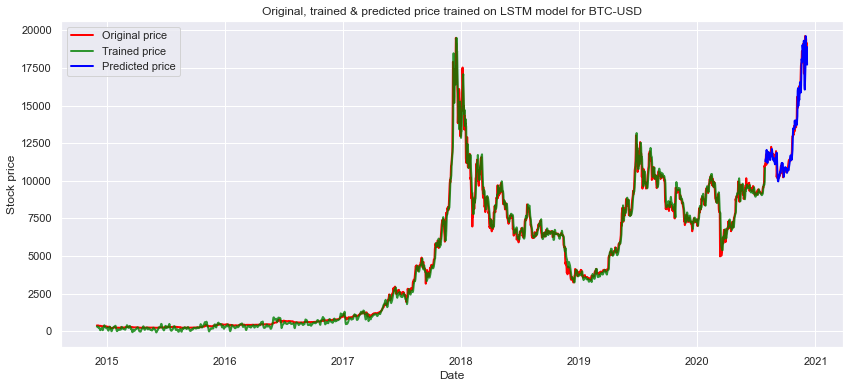

In [42]:
plot_prediction(df_final[['Adj Close']], df_final[['LSTM']] , train_set.shape[0], "LSTM")

## Backtesting: Long only strategy

In [43]:
def trading_signal(df):
    df['predicted_price'] = df.LSTM.shift(-1)
    df['Trade'] = np.where( df['Adj Close'] > df['predicted_price'], 1, 0)
    df['return'] = np.where( df['Trade'] == 1, df['Adj Close'].pct_change() , 0)
    df['Cummulative_Trade'] = (1 + df['return']).cumprod() - 1
    
    df['Cummulative_BTC'] = (1 + (df['Adj Close'].pct_change())).cumprod() - 1
    return df

In [47]:
df_trade = trading_signal(df_final.iloc[len(train_set)-time_steps:-2,])

In [45]:
df_trade.tail()

,Adj Close,LSTM,predicted_price,Trade,return,Cummulative_Trade,Cummulative_BTC
Date,,,,,,,
2020-11-30,19625.835938,16798.476562,17600.039062,1,0.079678,3.972455,1.074381
2020-12-01,18802.998047,17600.039062,19615.228516,0,0.000000,3.972455,0.987410
2020-12-02,19201.091797,19615.228516,17867.824219,1,0.021172,4.077731,1.029487
2020-12-03,19445.398438,17867.824219,18474.773438,1,0.012724,4.142338,1.055309
2020-12-04,18699.765625,18474.773438,NaN,0,0.000000,4.142338,0.976498


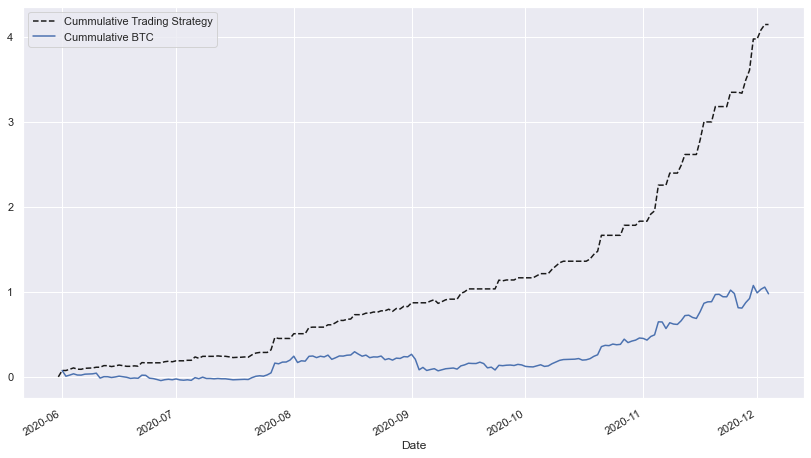

In [46]:
plt.figure(figsize=(14, 8))
df_trade['Cummulative_Trade'].plot(style='k--',label = "Cummulative Trading Strategy")
df_trade['Cummulative_BTC'].plot(label = "Cummulative BTC")
plt.legend()